# COMS W4705 - Homework 3
## Conditioned LSTM Language Model for Image Captioning
Daniel Bauer <bauer@cs.columbia.edu>

Follow the instructions in this notebook step-by step. Much of the code is provided (especially in part I, II, and III), but some sections are marked with **todo**. Make sure to complete all these sections. 

Specifically, you will build the following components: 

* Part I (14pts): Create encoded representations for the images in the flickr dataset using a pretrained image encoder(ResNet)
* Part II (14pts): Prepare the input caption data.
* Part III (24pts): Train an LSTM language model on the caption portion of the data and use it as a generator. 
* Part IV (24pts): Modify the LSTM model to also pass a copy of the input image in each timestep. 
* Part V (24pts): Implement beam search for the image caption generator.

As for homework 4, access to a GPU is required.

### Getting Started 

There are a few required packages. 

In [1]:
import os
import PIL # Python Image Library

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models import ResNet18_Weights

In [2]:
# For avoiding truncated outputs
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
torch.set_printoptions(profile="full")
np.set_printoptions(threshold=np.inf)

In [3]:
if torch.cuda.is_available(): 
    DEVICE = 'cuda'
elif torch.mps.is_available():
    DEVICE = 'mps'
else: 
    DEVICE = 'cpu'
    print("You won't be able to train the RNN decoder on a CPU, unfortunately.")
print(DEVICE)

mps


### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html 

If you are using Colab: 
* The data is available on google drive. You can access the folder here:
https://drive.google.com/drive/folders/1sXWOLkmhpA1KFjVR0VjxGUtzAImIvU39?usp=sharing
* Sharing is only enabled for the lionmail domain. Please make sure you are logged into Google Drive using your Columbia UNI. I will not be able to respond to individual sharing requests from your personal account. 

* Once you have opened the folder, click on "Shared With Me", then select the hw5data folder, and press shift+z. This will open the "add to drive" menu. Add the folder to your drive. (This will not create a copy, but just an additional entry point to the shared folder). 

N.B.: Usage of this data is limited to this homework assignment. If you would like to experiment with the dataset beyond this course, I suggest that you submit your own download request here (it's free): https://forms.illinois.edu/sec/1713398



If you are running the code locally (or on a cloud VM): I also placed a copy in a Google cloud storage bucket here:
https://storage.googleapis.com/4705-hw5-data/hw5data-20220809T182644Z-001.zip

In [ ]:
# OPTIONAL (if not using Colab and the data in Google Drive): Download the data.
!wget https://storage.googleapis.com/4705_fa24_hw3/hw3data.zip

In [ ]:
#Then unzip the data 
!unzip hw3data.zip

The following variable should point to the location where the data is located. 

In [4]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
MY_DATA_DIR="hw3data"

## Part I: Image Encodings (14 pts)

The files Flickr_8k.trainImages.txt Flickr_8k.devImages.txt Flickr_8k.testImages.txt, contain a list of training, development, and test images, respectively. Let's load these lists. 

In [5]:
def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

In [6]:
FLICKR_PATH="hw3data/"

In [7]:
train_list = load_image_list(os.path.join(FLICKR_PATH, 'Flickr_8k.trainImages.txt'))
dev_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.devImages.txt'))
test_list = load_image_list(os.path.join(FLICKR_PATH,'Flickr_8k.testImages.txt'))

Let's see how many images there are

In [8]:
len(train_list), len(dev_list), len(test_list)

(6000, 1000, 1000)

Each entry is an image filename.

In [9]:
dev_list[20]

'3693961165_9d6c333d5b.jpg'

The images are located in a subdirectory.  

In [10]:
IMG_PATH = os.path.join(FLICKR_PATH, "Flickr8k_Dataset")

We can use PIL to open and display the image:

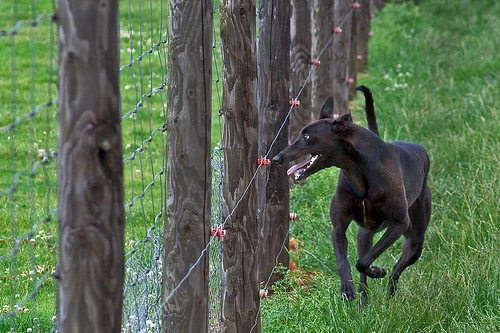

In [11]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image

### Preprocessing

We are going to use an off-the-shelf pre-trained image encoder, the ResNet-18 network. Here is more detail about this model (not required for this project): 

> Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun; Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778 
> https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

The model was initially trained on an object recognition task over the ImageNet1k data. The task is to predict the correct class label for an image, from a set of 1000 possible classes.

To feed the flickr images to ResNet, we need to perform the same normalization that was applied to the training images. More details here: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

In [12]:
from torchvision import transforms 

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The resulting images, after preprocessing, are (3,224,244) tensors, where the first dimension represents the three color channels, R,G,B).

In [13]:
processed_image = preprocess(image)
processed_image.shape

torch.Size([3, 224, 224])

To the ResNet18 model, the images look like this: 

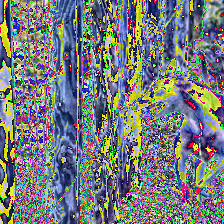

In [14]:
transforms.ToPILImage()(processed_image)

### Image Encoder
Let's instantiate the ReseNet18 encoder. We are going to use the pretrained weights available in torchvision.

In [15]:
img_encoder = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

In [16]:
img_encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 512. 

We will use the following hack: remove the last layer, then reinstantiate a Squential model from the remaining layers. 

In [17]:
lastremoved = list(img_encoder.children())[:-1]
img_encoder = torch.nn.Sequential(*lastremoved).to(DEVICE) # also send it to GPU memory
img_encoder.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Let's try the encoder.

In [18]:
def get_image(img_name): 
    image = PIL.Image.open(os.path.join(IMG_PATH, img_name))
    return preprocess(image)

In [19]:
preprocessed_image = get_image(train_list[0])
encoded = img_encoder(preprocessed_image.unsqueeze(0).to(DEVICE)) # unsqueeze required to add batch dim (3,224,224) becomes (1,3,224,224)
encoded.shape                      

torch.Size([1, 512, 1, 1])

The result isn't quite what we wanted: The final representation is actually a 1x1 "image" (the first dimension is the batch size). 
We can just grab this one pixel:

In [20]:
encoded = encoded[:,:,0,0] #this is our final image encoded
encoded.shape 

torch.Size([1, 512])

**TODO:** Because we are just using the pretrained encoder, we can simply encode all the images in a preliminary step. We will store them in one big tensor (one for each dataset, train, dev, test). This will save some time when training the conditioned LSTM because we won't have to recompute the image encodings with each training epoch. We can also save the tensors to disk so that we never have to touch the bulky image data again.

Complete the following function that should take a list of image names and return a tensor of size [n_images, 512] (where each row represents one image). 

For example `encode_imates(train_list)` should return a [6000,512] tensor. 

In [21]:
def encode_images(image_list): 
    encoded_images = []
    with torch.no_grad():
        for img_name in image_list:
            preprocessed_image = get_image(img_name)
            encoded = img_encoder(preprocessed_image.unsqueeze(0).to(DEVICE))
            encoded = encoded[:, :, 0, 0]
            encoded_images.append(encoded.squeeze(0).cpu())
    return torch.stack(encoded_images)
           
enc_images_train = encode_images(train_list)
enc_images_train.shape

torch.Size([6000, 512])

We can now save this to disk:

In [22]:
torch.save(enc_images_train, open('encoded_images_train.pt','wb'))

It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

## Part II Text (Caption) Data Preparation (14 pts)

Next, we need to load the image captions and generate training data for the language model. We will train a text-only model first.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. 
The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a \<START\> token on the left and an \<END\> token on the right. 

For example, a single caption might look like this: 
['\<START\>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '\<EOS\>'],

In [23]:
def read_image_descriptions(filename):    
    image_descriptions = {}    
    with open(filename, 'r') as in_file:
        for line in in_file:
            parts = line.strip().split('\t')
            image_filename = parts[0].split('#')[0]
            caption = ['<START>'] + parts[1].lower().split() + ['<EOS>']        
            if image_filename not in image_descriptions:
                image_descriptions[image_filename] = []     
            image_descriptions[image_filename].append(caption) 
    return image_descriptions

In [24]:
os.path.join(FLICKR_PATH, "Flickr8k.token.txt")

'hw3data/Flickr8k.token.txt'

In [25]:
descriptions = read_image_descriptions(os.path.join(FLICKR_PATH, "Flickr8k.token.txt"))

In [26]:
descriptions['1000268201_693b08cb0e.jpg']

[['<START>',
  'a',
  'child',
  'in',
  'a',
  'pink',
  'dress',
  'is',
  'climbing',
  'up',
  'a',
  'set',
  'of',
  'stairs',
  'in',
  'an',
  'entry',
  'way',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'girl',
  'going',
  'into',
  'a',
  'wooden',
  'building',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'into',
  'a',
  'wooden',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'climbing',
  'the',
  'stairs',
  'to',
  'her',
  'playhouse',
  '.',
  '<EOS>'],
 ['<START>',
  'a',
  'little',
  'girl',
  'in',
  'a',
  'pink',
  'dress',
  'going',
  'into',
  'a',
  'wooden',
  'cabin',
  '.',
  '<EOS>']]

The previous line should return 
<pre>[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<EOS>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<EOS>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<EOS>']]</pre>

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. 

**TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. This is similar to the word indices you created for homework 3 and 4.  

Make sure you create word indices for the three special tokens `<PAD>`, `<START>`, and `<EOS>` (end of sentence).

In [27]:
id_to_word = {}
id_to_word[0] = "<PAD>"
id_to_word[1] = "<START>"
id_to_word[2] = "<EOS>"

word_to_id = {v: k for k, v in id_to_word.items()}

def create_vocab(image_descriptions):
    vocab = set()
    for captions in image_descriptions.values():
        for caption in captions:
            vocab.update(caption)
    return sorted(vocab)

vocab = create_vocab(descriptions)

for idx, word in enumerate(vocab, start=len(id_to_word)):
    id_to_word[idx] = word
    word_to_id[word] = idx

In [28]:
word_to_id['cat'] # should print an integer

1351

In [29]:
id_to_word[1] # should print a token

'<START>'

Note that we do not need an UNK word token because we will only use the model as a generator, once trained.

## Part III Basic Decoder Model (24 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

We will use the LSTM implementation provided by PyTorch. The core idea here is that the recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different position, but the weights for these positions are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [30]:
MAX_LEN = max(len(description) for image_id in train_list for description in descriptions[image_id])
MAX_LEN

40

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '<EOS>']`

We would train the model using the following input/output pairs (note both sequences are padded to the right up to MAX_LEN)

| i | input                                 | output                              |
|---|---------------------------------------|-------------------------------------|
| 0 |[`<START>`,`<PAD>`,`<PAD>`,`<PAD>`,...]| [`a`,`<PAD>`,`<PAD>`,`<PAD>`,...    |  
| 1 |[`<START>`,`a`,`<PAD>`,`<PAD>`,...]    | [`a`,`black`,`<PAD>`,`<PAD>`,...    |
| 2 |[`<START>`,`a`,`black`,`<PAD>`,...]    | [`a`,`black`,`dog`,`<PAD>`,...      |
| 3 |[`<START>`,`a`,`back`,`dog`,...]       | [`a`,`black`,`dog`,`<EOS>`,...      |

Here is the lange model in pytorch. We will choose input embeddings of dimensionality 512 (for simplicitly, we are not initializing these with pre-trained embeddings here). We will also use 512 for the hidden state vector and the output. 

In [31]:
from torch import nn 

vocab_size = len(word_to_id)+1
class GeneratorModel(nn.Module): 
    
    def __init__(self): 
        super(GeneratorModel, self).__init__()    
        self.embedding = nn.Embedding(vocab_size, 512) 
        self.lstm = nn.LSTM(512, 512, num_layers = 1, bidirectional=False, batch_first=True)
        self.output = nn.Linear(512,vocab_size)
        
    def forward(self, input_seq): 
        hidden = self.lstm(self.embedding(input_seq))
        out = self.output(hidden[0])
        return out

The input sequence is an integer tensor of size `[batch_size, MAX_LEN]`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with '<PAD>'.

For each input example, the model returns a distribution over possible output words. The model output is a tensor of size `[batch_size, MAX_LEN, vocab_size]`. vocab_size is the number of vocabulary words, i.e. len(word_to_id)

### Creating a Dataset for the text training data

**TODO**: Write a Dataset class for the text training data. The __getitem__ method should return an (input_encoding, output_encoding) pair for a single item. Both input_encoding and output_encoding should be tensors of size `[MAX_LEN]`, encoding the padded input/output sequence as illustrated above. 

I recommend to first read in all captions in the __init__ method and store them in a list. Above, we used the get_image_descriptions function to load the image descriptions into a dictionary. Iterate through the images in img_list, then access the corresponding captions in the `descriptions` dictionary. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


In [32]:
class CaptionDataset(Dataset):
    
    def __init__(self, img_list):
        self.data = []
        for img_name in img_list:
            if img_name in descriptions:
                captions = [[token for token in caption if token not in ['<START>', '<END>']] 
                          for caption in descriptions[img_name]]
                self.data.extend(captions)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, k):
        caption = self.data[k]
        
        input_enc = torch.zeros(MAX_LEN, dtype=torch.long)
        output_enc = torch.zeros(MAX_LEN, dtype=torch.long)
        input_enc[0] = 1  
        for i in range(len(caption)):
            if i + 1 < MAX_LEN:
                input_enc[i + 1] = word_to_id[caption[i]]
                output_enc[i] = word_to_id[caption[i]]
        if len(caption) + 1 < MAX_LEN:
            input_enc[len(caption) + 1] = 2
        if len(caption) < MAX_LEN:
            output_enc[len(caption)] = 2
        
        return input_enc, output_enc

Let's instantiate the caption dataset and get the first item. You want to see something like this: 

for the input: 
<pre>
tensor([   1,   74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922,
        7125,   17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>
for the output:
<pre>
    tensor([  74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922, 7125,
          17,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
</pre>

In [33]:
data = CaptionDataset(train_list)

In [34]:
i, o = data[0]
i

tensor([   1,   74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922,
        7125,   17,   71,    2,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

In [35]:
o

tensor([  74,  805, 2312, 4015, 6488,  170,   74, 8686, 2312, 3922, 7922, 7125,
          17,   71,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])

Let's try the model:

In [36]:
model = GeneratorModel().to(DEVICE)

In [37]:
model(i.to(DEVICE)).shape   # should return a [40, vocab_size]  tensor.

torch.Size([40, 8922])

### Training the Model

The training function is identical to what you saw in homework 3 and 4.

In [38]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
loader = DataLoader(data, batch_size = 16, shuffle = True)
def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):

        inputs,targets = batch   
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        # Run the forward pass of the model
        logits = model(inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            #torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")
    return epoch_accuracy

Run the training until the accuracy reaches about 0.5 (this would be high for a language model on open-domain text, but the image caption dataset is comparatively small and closed-domain). This will take about 5 epochs.

In [39]:
def train_until_accuracy(target_accuracy=0.5, max_epochs=50):
    current_epoch = 0   
    while current_epoch < max_epochs:      
        epoch_accuracy = train()  
        if epoch_accuracy >= target_accuracy:
            break       
        current_epoch += 1
    


train_until_accuracy() # I ran until getting 0.5 or higher acc

Current average loss: 9.09692096710205
Current average loss: 4.625590815402494
Current average loss: 4.160791267803059
Current average loss: 3.914675623871559
Current average loss: 3.781626410020557
Current average loss: 3.6759886289547063
Current average loss: 3.594078873635925
Current average loss: 3.5242329517886914
Current average loss: 3.4707593646984125
Current average loss: 3.427656351263065
Current average loss: 3.3872756212503163
Current average loss: 3.353395680315813
Current average loss: 3.3222752588178395
Current average loss: 3.2948409843957944
Current average loss: 3.2687349486231887
Current average loss: 3.248550696344395
Current average loss: 3.2295032524451996
Current average loss: 3.2101324259148565
Current average loss: 3.192574393411665
Training loss epoch: 3.1796750109354655
Average accuracy epoch: 0.42
Current average loss: 2.7229576110839844
Current average loss: 2.628196898073253
Current average loss: 2.6335522725214413
Current average loss: 2.622185547090448
C

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>", "<PAD>","<PAD>"...]`, use the model to predict the most likely word in the next position. Append the word to the input sequence and then continue until `"<EOS>"` is predicted or the sequence reaches `MAX_LEN` words. 

In [43]:
def decoder():
    input_seq = torch.zeros(MAX_LEN, dtype=torch.long).to(DEVICE)
    input_seq[0] = word_to_id["<START>"]
    generated_words = []
    
    for i in range(1, MAX_LEN):
        logits = model(input_seq.unsqueeze(0))
        next_word_id = torch.argmax(logits[0, i - 1]).item()
        generated_words.append(id_to_word[next_word_id])
        
        if id_to_word[next_word_id] == "<EOS>":
            break
        
        input_seq[i] = next_word_id
    
    return generated_words

In [44]:
decoder()

['thumbs-up',
 'nude',
 'amazed',
 'woman',
 'wearing',
 'a',
 'black',
 'jacket',
 'and',
 'hat',
 '.',
 '<EOS>']

this will return something like 
['a',
 'man',
 'in',
 'a',
 'white',
 'shirt',
 'and',
 'a',
 'woman',
 'in',
 'a',
 'white',
 'dress',
 'walks',
 'by',
 'a',
 'small',
 'white',
 'building',
 '.',
 '<EOS>']

This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

**TODO:** Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Make sure to apply torch.softmax() to convert the output activations into a distribution. 

To sample fromt he distribution, I recommend you take a look at [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), which takes the distribution as a parameter p.

In [45]:
def sample_decoder():
    input_seq = torch.zeros(MAX_LEN, dtype=torch.long).to(DEVICE)
    input_seq[0] = word_to_id["<START>"]
    generated_words = ["<START>"]
    
    for i in range(1, MAX_LEN):
        logits = model(input_seq.unsqueeze(0))
        softmax_probs = torch.softmax(logits[0, i - 1], dim=0).cpu().detach().numpy()
        
        next_word_id = np.random.choice(len(softmax_probs), p=softmax_probs)
        next_word = id_to_word[next_word_id]
        generated_words.append(next_word)
        
        if next_word == "<EOS>":
            break
        
        input_seq[i] = next_word_id
    
    return generated_words

for i in range(5):
    print(sample_decoder())

['<START>', 'dandelion', 'camcorder', 'rust', 'measured', 'corkscrew', 'first', 'stop', 'bucking', 'sticking', '<EOS>']
['<START>', 'fan', 'europe', 'rafter', 'knitted', 'counters', 'spider-patterned', 'bronze', 'ponytailed', 'terrior', 'canadian', 'flip-flop', 'gauges', 'state', 'snack', 'sled-like', '157', 'waterway', 'carpeted', 'stump', 'peeks', 'though', 'is', 'smelling', 'erupts', 'on', 'trail', 'covered', 'by', 'background', '.', '<EOS>']
['<START>', 'passing', 'goats', 'expressionless', 'body-board', 'diry', 'magizine', 'battling', 'nip', 'anchored', '<EOS>']
['<START>', 'goatee', 'eyes', 'fangs', 'flailing', 'surfboarding', 'straddles', 'waterproofs', 'joust', 'speaks', 'into', 'the', 'ocean', "'s", 'sky', '.', '<EOS>']
['<START>', 'eastern', 'outfit', 'quietly', 'amplifier', 'whack', 'sees', 'raft', 'sitting', 'tool', 'before', 'shop', 'is', 'covered', 'in', 'flowers', '.', '<EOS>']


Some example outputs (it's stochastic, so your results will vary 

<pre>
['<START>', 'people', 'on', 'rocky', 'ground', 'swinging', 'basketball', '<EOS>']
['<START>', 'the', 'two', 'hikers', 'take', 'a', 'tandem', 'leap', 'while', 'another', 'is', 'involving', 'watching', '.', '<EOS>']
['<START>', 'a', 'man', 'attached', 'to', 'a', 'bicycle', 'rides', 'a', 'motorcycle', '.', '<EOS>']
['<START>', 'a', 'surfer', 'is', 'riding', 'a', 'wave', 'in', 'the', 'ocean', '.', '<EOS>']
['<START>', 'a', 'child', 'plays', 'in', 'a', 'round', 'fountain', '.', '<EOS>']
</pre>

You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

## Part III - Conditioning on the Image (24 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will concatenate the 512-dimensional image representation to each 512-dimensional token embedding. The LSTM will therefore see input representations of size 1024.

**TODO**: Write a new Dataset class for the combined image captioning data set. Each call to __getitem__ should return a triple  (image_encoding, input_encoding, output_encoding) for a single item. Both input_encoding and output_encoding should be tensors of size [MAX_LEN], encoding the padded input/output sequence as illustrated above. The image_encoding is the size [512] tensor we pre-computed in part I.

Note: One tricky issue here is that each image corresponds to 5 captions, so you have to find the correct image for each caption. You can create a mapping from image names to row indices in the image encoding tensor. This way you will be able to find each image by it's name. 

In [46]:
class CaptionAndImage(Dataset):
    
    def __init__(self, img_list):
        self.img_data = torch.load(open("encoded_images_train.pt",'rb'))
        self.img_name_to_id = dict([(i,j) for (j,i) in enumerate(img_list)])

        self.data = []
        for img_name in img_list:
            captions = descriptions[img_name]
            for caption in captions:
                self.data.append((img_name, caption))
                
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, k):
        img_name, caption = self.data[k]
        
        img_data = self.img_data[self.img_name_to_id[img_name]]
        
        input_enc = torch.zeros(MAX_LEN, dtype=torch.long)
        output_enc = torch.zeros(MAX_LEN, dtype=torch.long)
        
        input_enc[0] = word_to_id["<START>"]
        
        for i in range(len(caption)):
            if i + 1 < MAX_LEN - 1:
                input_enc[i + 1] = word_to_id[caption[i]]
                output_enc[i] = word_to_id[caption[i]]
        
        if len(caption) + 1 < MAX_LEN:
            input_enc[len(caption) + 1] = word_to_id["<EOS>"]
        if len(caption) < MAX_LEN:
            output_enc[len(caption)] = word_to_id["<EOS>"]
        
        return img_data, input_enc, output_enc

In [47]:
joint_data = CaptionAndImage(train_list)
img, i, o = joint_data[0]
img.shape # should return torch.Size([512])

/var/folders/br/9yd_4ty57bb499st_cjhqynm0000gn/T/ipykernel_89179/4008099829.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.img_data = torch.load(open("encoded_imag

torch.Size([512])

In [48]:
i.shape # should return torch.Size([40])

torch.Size([40])

In [49]:
o.shape # should return torch.Size([40])

torch.Size([40])

**TODO: Updating the model**
Update the language model code above to include a copy of the image for each position. 
The forward function of the new model should take two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

The LSTM will take input dimension 1024 instead of 512 (because we are concatenating the 512-dim image encoding). 

In the forward function, take the image and the embedded input sequence (i.e. AFTER the embedding was applied), and concatenate the image to each input. This requires some tensor manipulation. I recommend taking a look at [torch.Tensor.expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) and [torch.Tensor.cat](https://pytorch.org/docs/stable/generated/torch.Tensor.cat.html).



In [50]:
vocab_size = len(word_to_id) + 1

class CaptionGeneratorModel(nn.Module): 
    
    def __init__(self): 
        super(CaptionGeneratorModel, self).__init__()    
        self.embedding = nn.Embedding(vocab_size, 512) 
        self.lstm = nn.LSTM(1024, 512, num_layers=1, bidirectional=False, batch_first=True)
        self.output = nn.Linear(512, vocab_size)
        
    def forward(self, img, input_seq): 
        embedded = self.embedding(input_seq)
        
        img_expanded = img.unsqueeze(1).expand(-1, embedded.size(1), -1)
        combined = torch.cat([embedded, img_expanded], dim=2)
        
        hidden, _ = self.lstm(combined)
        out = self.output(hidden)
        
        return out

Let's try this new model on one item: 

In [51]:
model = CaptionGeneratorModel().to(DEVICE)

In [52]:
item = joint_data[0]
img, input_seq, output_seq = item

In [53]:
logits = model(img.unsqueeze(0).to(DEVICE), input_seq.unsqueeze(0).to(DEVICE))

logits.shape # should return (1,40,8922) = (batch_size, MAX_LEN, vocab_size)

torch.Size([1, 40, 8922])

The training function is, again, mostly unchanged. Keep training until the accuracy exceeds 0.5.

In [54]:
from torch.nn import CrossEntropyLoss
loss_function = CrossEntropyLoss(ignore_index = 0, reduction='mean')

LEARNING_RATE = 1e-03
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

loader = DataLoader(joint_data, batch_size = 16, shuffle = True)
epoch_accuracy = 0
def train():
    """
    Train the model for one epoch.
    """
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    total_correct, total_predictions = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(loader):
        
        img, inputs,targets = batch  
        img = img.to(DEVICE)
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        
        # Run the forward pass of the model
        logits = model(img, inputs)
        loss = loss_function(logits.transpose(2,1), targets)
        tr_loss += loss.item()
        #print("Batch loss: ", loss.item()) # can comment out if too verbose.
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=2)  # Predicted token labels
        not_pads = targets != 0  # Mask for non-PAD tokens
        correct = torch.sum((predictions == targets) & not_pads)
        total_correct += correct.item()
        total_predictions += not_pads.sum().item()

        if idx % 100==0:
            #torch.cuda.empty_cache() # can help if you run into memory issues
            curr_avg_loss = tr_loss/nb_tr_steps
            print(f"Current average loss: {curr_avg_loss}")

        # Run the backward pass to update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy for this batch
        # matching = torch.sum(torch.argmax(logits,dim=2) == targets)
        # predictions = torch.sum(torch.where(targets==-100,0,1))

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accuracy = total_correct / total_predictions if total_predictions != 0 else 0  # Avoid division by zero
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Average accuracy epoch: {epoch_accuracy:.2f}")
    return epoch_accuracy

In [56]:
def train_until_accuracy(target_accuracy=0.5, max_epochs=50):
    current_epoch = 0   
    while current_epoch < max_epochs:      
        epoch_accuracy = train()  
        if epoch_accuracy > target_accuracy:
            break       
        current_epoch += 1
    


train_until_accuracy() # I ran until getting higher than 0.5 acc

Current average loss: 9.082108497619629
Current average loss: 4.402491132811744
Current average loss: 3.9774260924230167
Current average loss: 3.7671552187580604
Current average loss: 3.612080720297416
Current average loss: 3.4973811846293374
Current average loss: 3.4118269243573587
Current average loss: 3.3405755229411214
Current average loss: 3.2814347943414313
Current average loss: 3.2273550470184937
Current average loss: 3.185171829236971
Current average loss: 3.145368629103894
Current average loss: 3.109486589622339
Current average loss: 3.076993945925901
Current average loss: 3.046844027367428
Current average loss: 3.019815234801199
Current average loss: 2.9961538621591526
Current average loss: 2.9709150014660906
Current average loss: 2.95025577735795
Training loss epoch: 2.935423401133219
Average accuracy epoch: 0.47
Current average loss: 2.5213639736175537
Current average loss: 2.381685449345277
Current average loss: 2.382173051881553
Current average loss: 2.386469163371875
Cur

**TODO: Testing the model**: 
Rewrite the greedy decoder from above to take an encoded image representation as input.

In [57]:
def greedy_decoder(img):
    input_seq = torch.zeros(MAX_LEN, dtype=torch.long).to(DEVICE)
    input_seq[0] = word_to_id["<START>"]
    generated_words = []
    
    for i in range(1, MAX_LEN):
        logits = model(img.unsqueeze(0), input_seq.unsqueeze(0))
        next_word_id = torch.argmax(logits[0, i - 1]).item()
        generated_words.append(id_to_word[next_word_id])
        
        if id_to_word[next_word_id] == "<EOS>":
            break
        
        input_seq[i] = next_word_id
    
    return generated_words

Now we can load one of the dev images, pass it through the preprocessor and the image encoder, and then into the decoder!

['<START>', 'a', 'skier', 'is', 'jumping', 'on', 'a', 'snowy', 'hill', '.', '<EOS>']


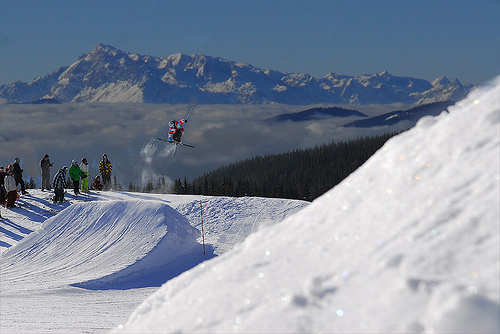

In [58]:
raw_img = PIL.Image.open(os.path.join(IMG_PATH, dev_list[148]))
preprocessed_img = preprocess(raw_img).to(DEVICE)
encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))
caption = greedy_decoder(encoded_img)
print(caption)
raw_img

The result should look pretty good for most images, but the model is prone to hallucinations. 

## Part IV - Beam Search Decoder (24 pts)

**TODO** Modify the simple greedy decoder for the caption generator to use beam search. 
Instead of always selecting the most probable word, use a *beam*, which contains the n highest-scoring sequences so far and their total probability (i.e. the product of all word probabilities). I recommend that you use a list of `(probability, sequence)` tuples. After each time-step, prune the list to include only the n most probable sequences. 

Then, for each sequence, compute the n most likely successor words. Append the word to produce n new sequences and compute their score. This way, you create a new list of n*n candidates. 

Prune this list to the best n as before and continue until `MAX_LEN` words have been generated. 

Note that you cannot use the occurence of the `"<EOS>"` tag to terminate generation, because the tag may occur in different positions for different entries in the beam. 

Once `MAX_LEN` has been reached, return the most likely sequence out of the current n. 

In [59]:
def img_beam_decoder(n, img):
    beam = [(1.0, [word_to_id["<START>"]])]
    completed_sequences = []

    for step in range(MAX_LEN - 1):
        candidates = []

        for prob, seq in beam:
            if seq[-1] == word_to_id["<EOS>"]:
                completed_sequences.append((prob, seq))
                continue
            input_seq = torch.zeros(MAX_LEN, dtype=torch.long).to(DEVICE)
            input_seq[:len(seq)] = torch.tensor(seq).to(DEVICE)
            logits = model(img.unsqueeze(0), input_seq.unsqueeze(0))
            probabilities = torch.softmax(logits[0, len(seq) - 1], dim=0).cpu().detach().numpy()

            for next_word_id in np.argsort(probabilities)[-n:]:
                if next_word_id == word_to_id["<START>"]:
                    continue

                new_prob = prob * probabilities[next_word_id]
                new_seq = seq + [next_word_id]
                candidates.append((new_prob, new_seq))

        if not candidates:
            break

        beam = sorted(candidates, key=lambda x: x[0], reverse=True)[:n]
    completed_sequences.extend(beam)
    best_sequence = max(completed_sequences, key=lambda x: x[0])[1]
    
    return [id_to_word[word_id] for word_id in best_sequence]

**TODO** Finally, before you submit this assignment, please show 3 development images, each with 1) their greedy output, 2) beam search at n=3 3) beam search at n=5. 

Image: 3335692531_dd4a995f91.jpg
Greedy Output: ['<START>', 'two', 'dogs', 'are', 'playing', 'on', 'a', 'grassy', 'field', '.', '<EOS>']
Beam Search Output (n=3): ['<START>', 'a', 'brown', 'dog', 'with', 'a', 'toy', 'in', 'its', 'mouth', '.', '<EOS>']
Beam Search Output (n=5): ['<START>', 'a', 'brown', 'dog', 'with', 'a', 'toy', 'in', 'its', 'mouth', '.', '<EOS>']


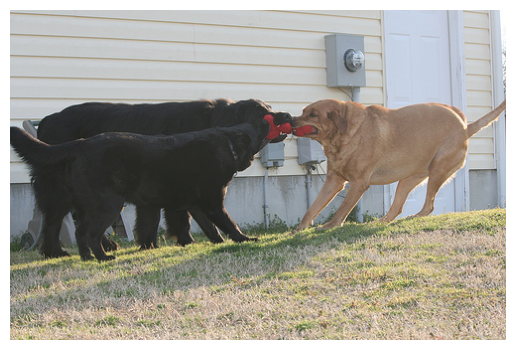

Image: 300765528_8c8f709dda.jpg
Greedy Output: ['<START>', 'a', 'group', 'of', 'people', 'are', 'standing', 'in', 'a', 'crowd', '.', '<EOS>']
Beam Search Output (n=3): ['<START>', 'a', 'group', 'of', 'people', 'are', 'standing', 'in', 'a', 'crowd', '.', '<EOS>']
Beam Search Output (n=5): ['<START>', 'a', 'group', 'of', 'people', 'in', 'a', 'crowd', '.', '<EOS>']


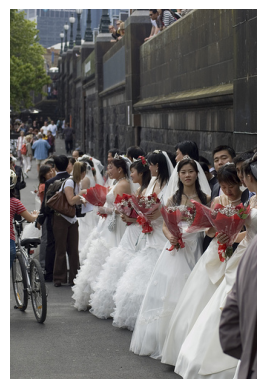

Image: 1420060118_aed262d606.jpg
Greedy Output: ['<START>', 'a', 'girl', 'in', 'a', 'black', 'shirt', 'is', 'jumping', 'on', 'a', 'tree', '.', '<EOS>']
Beam Search Output (n=3): ['<START>', 'a', 'girl', 'in', 'a', 'tree', '.', '<EOS>']
Beam Search Output (n=5): ['<START>', 'a', 'girl', 'in', 'a', 'tree', '.', '<EOS>']


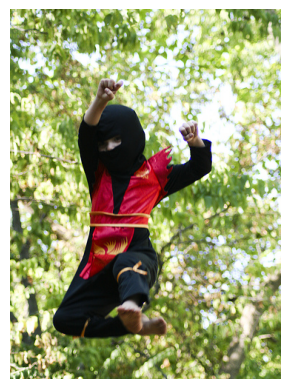

In [81]:
import matplotlib.pyplot as plt

def show_results_with_images(dev_list, indices, n1=3, n2=5):
    for idx in indices:
        img_name = dev_list[idx]
        raw_img = PIL.Image.open(os.path.join(IMG_PATH, img_name))
        preprocessed_img = preprocess(raw_img).to(DEVICE)
        encoded_img = img_encoder(preprocessed_img.unsqueeze(0)).reshape((512))

        caption_greedy = greedy_decoder(encoded_img)
        caption_beam_n3 = img_beam_decoder(n1, encoded_img)
        caption_beam_n5 = img_beam_decoder(n2, encoded_img)

        print(f"Image: {img_name}")
        print("Greedy Output:", caption_greedy)
        print(f"Beam Search Output (n={n1}):", caption_beam_n3)
        print(f"Beam Search Output (n={n2}):", caption_beam_n5)
        
        plt.imshow(raw_img)
        plt.axis('off')
        plt.show()
show_results_with_images(dev_list, indices=[226, 168, 131])
